# Sentiment Analysis using Tensorflow

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split

### Load data

In [2]:
LOCAL_DATA_FILE = "data\cTweets.csv"

df = pd.read_csv(LOCAL_DATA_FILE, names=["textID","text","sentiment"])

df.head(5)

,textID,text,sentiment
0,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,positive
1,vcu451,Reading my kindle2... Love it... Lee childs i...,positive
2,mandanicole,how can you not love Obama? he makes jokes abo...,positive
3,kylesellers,@Karoli I firmly believe that Obama/Pelosi hav...,negative
4,theviewfans,House Correspondents dinner was last night who...,positive


### Describe Data

Show distribution of sentiment lables in the datafile

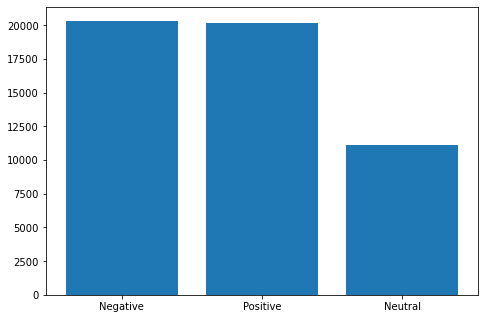

In [3]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
polarity = ['Negative', 'Positive', 'Neutral']
value = [df['sentiment'].value_counts()[0],df['sentiment'].value_counts()[1],df['sentiment'].value_counts()[2]]
ax.bar(polarity,value)
plt.show()

In [4]:
df['sentiment'].value_counts()

positive    20350
negative    20198
neutral     11118
Name: sentiment, dtype: int64

### Process and clean data for use in model

In [5]:
def clean_text(text):
  text = re.sub("[^a-zA-Z]"," ",str(text))      # Replace all non-letters with spaces
  text = re.sub(r'@[A-Za-z0-9]+', '', text)     # Remove @mentions
  text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # Remove @mentions 
  text = re.sub(r'@[A-Za-z]+', '', text)        # Remove @mentions
  text = re.sub(r'@[-)]+', '', text)            # Remove @mentions
  text = re.sub(r'#', '', text )                # Remove '#' sign
  text = re.sub(r'RT[\s]+', '', text)           # Remove RT
  text = re.sub(r'https?\/\/\S+', '', text)     # Remove the hyper link
  text = re.sub(r'&[a-z;]+', '', text)          # Remove '&gt;'
  text = re.sub("\s\s+", " ", (text))           # Remove excess whitespace
  return text

In [6]:
df = df.drop(columns='textID')
df = df[df.sentiment != "neutral"]

df.text = df.text.apply(clean_text)

df = df.replace("negative", 0.0)
df = df.replace("positive", 1.0)

df = df.sample(frac=1).reset_index(drop=True)

df.head(5)

,text,sentiment
0,Sure its easier to login every day and make p...,1.0
1,BankyHype or she could have just realized in ...,0.0
2,iamshur http cadence latchmered org new blog,1.0
3,Heading to quot hope in the city quot benefit ...,1.0
4,Just finished reading Chuck Palahniuk s Pygmy ...,0.0


Split the data into two sets, training data and testing data

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df['text'].values, df['sentiment'].values,test_size=0.30)

Convert the text strings into integers by using Tokenizer. Check the word index and set the vocabulary 

In [8]:
VOCAB_SIZE = 2000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
wordIndex = tokenizer.word_index
vocab = len(wordIndex)

print('Vocabulary size: ', vocab)

Vocabulary size:  31753


Convert the data into sequences

In [9]:
train_seq = tokenizer.texts_to_sequences(x_train)
test_seq = tokenizer.texts_to_sequences(x_test)

print('Training sequence: ', train_seq[0])
print('Testing sequence: ', test_seq[0])

Training sequence:  [6, 513, 2767]
Testing sequence:  [7507, 393, 52, 1174, 45, 3981, 1, 126, 19, 2, 42, 397, 514, 533, 14, 397, 1431, 198]


Add padding to both sequences

In [10]:
pad_train = pad_sequences(train_seq)
T = pad_train.shape[1]
print('Training sequence length: ', T)

Training sequence length:  48


In [11]:
pad_test = pad_sequences(test_seq, maxlen=T)
print('Testing sequence length: ', pad_test.shape[1])

Testing sequence length:  48


### Build the Model

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(T, )))
model.add(tf.keras.layers.Embedding(vocab+1, 20))
model.add(tf.keras.layers.LSTM(15, return_sequences=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Compile the Model

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])              

### Train the Model

In [14]:
history = model.fit(pad_train, y_train, validation_data=(pad_test, y_test), epochs=10, validation_steps=30)

Epoch 1/10
887/887 [==============================] - 10s 7ms/step - loss: 0.6855 - accuracy: 0.5761 - val_loss: 0.6545 - val_accuracy: 0.7038
Epoch 2/10
887/887 [==============================] - 6s 7ms/step - loss: 0.5738 - accuracy: 0.7578 - val_loss: 0.5332 - val_accuracy: 0.7636
Epoch 3/10
887/887 [==============================] - 6s 7ms/step - loss: 0.4465 - accuracy: 0.8209 - val_loss: 0.4709 - val_accuracy: 0.7869
Epoch 4/10
887/887 [==============================] - 6s 7ms/step - loss: 0.3716 - accuracy: 0.8536 - val_loss: 0.4610 - val_accuracy: 0.7929
Epoch 5/10
887/887 [==============================] - 6s 7ms/step - loss: 0.3211 - accuracy: 0.8774 - val_loss: 0.4615 - val_accuracy: 0.7975
Epoch 6/10
887/887 [==============================] - 6s 7ms/step - loss: 0.2823 - accuracy: 0.8953 - val_loss: 0.4727 - val_accuracy: 0.7973
Epoch 7/10
887/887 [==============================] - 6s 7ms/step - loss: 0.2481 - accuracy: 0.9107 - val_loss: 0.4866 - val_accuracy: 0.7953
Epoch

### Evaluate the Model

In [163]:
eval_loss, eval_acc = model.evaluate(pad_train, y_train)

print('Loss:', eval_loss)
print('Accuracy:', eval_acc)

887/887 [==============================] - 3s 4ms/step - loss: 0.1391 - accuracy: 0.9571
Loss: 0.13905034959316254
Accuracy: 0.9571222066879272


Plotting the accuracy, validation accuracy, loss, and validation loss of the model

In [164]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7123437531292438)

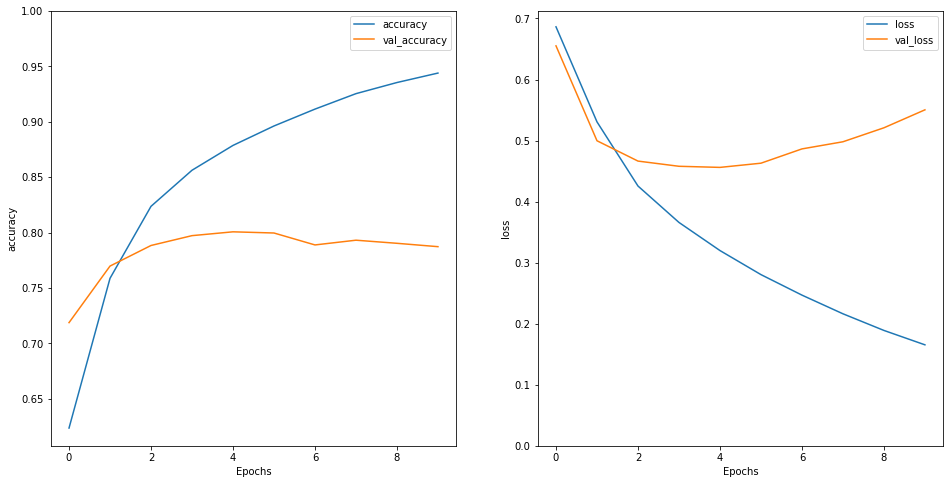

In [165]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### Create a function that will use the Model to predict sentiment of a given string

In [301]:
def predict_sentiment(text):
  text_seq = tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=T)
  
  sentiment_value = model.predict(text_pad)[0][0]

  print(text)
  if sentiment_value < 0.40:
    return(print('NEGATIVE: ',sentiment_value))
  elif sentiment_value < 0.60:
    return(print('NEUTRAL: ',sentiment_value))
  else: 
    return(print('POSITIVE: ',sentiment_value)) 

In [297]:
def get_sentiment(text):
  text_seq = tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=T)
  
  sentiment_value = model.predict(text_pad)[0][0]
  return(sentiment_value)

#### Predict sample text

In [298]:
positive_text = ['What a wonderful day. Im so happy.']
negative_text = ['That movie was terrible! I want my money back.']

predict_sentiment(positive_text)
predict_sentiment(negative_text)

1/1 [==============================] - 0s 17ms/step
['What a wonderful day. Im so happy.']
POSITIVE:  0.988976
1/1 [==============================] - 0s 17ms/step
['That movie was terrible! I want my money back.']
NEGATIVE:  0.021681963


### ↓ Insert custom text below ↓
- Insert the text on the sample_line between the quotes ['  '].
- Then run the code block below.
- *Do not use quotes "" or apostrophes '' inside the custom text*

1/1 [==============================] - 0s 17ms/step
['What a wonderful day. Im so happy.']
POSITIVE:  0.988976
1/1 [==============================] - 0s 26ms/step


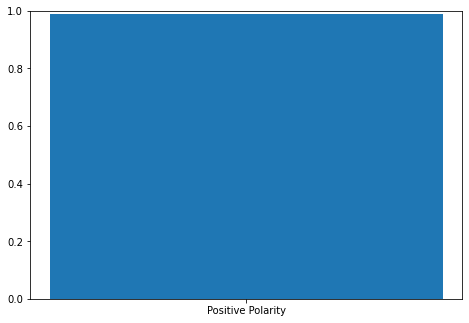

In [300]:
####################################################################
################ INSERT TEXT BELOW #################################

sample_text = ['That movie was terrible']

################ INSERT TEXT ABOVE #################################

# example_text_here1 = ['What a wonderful day. Im so happy.']

####################################################################

predict_sentiment(sample_text)
x = get_sentiment(sample_text)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
polarity = ['Positive Polarity']
value = [x]
ax.bar(polarity,value)
ax.set_ylim([0, 1])
plt.axhline(y=0.3,linewidth=1, color='r')
plt.axhline(y=0.6,linewidth=1, color='b')
plt.show()